In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from sig_proc import lfca
import numpy as np
import scipy as sp
import cartopy
import cartopy.crs as ccrs
import nclcmaps as ncm
from cartopy.util import add_cyclic_point
from datetime import datetime, timedelta
import pandas as pd

In [2]:
# import surface temperature file
filepath="C:/Users/sydne/OneDrive/Documents/LFCA_precip_temp/LFCA_precip_temp/observations/temperature_197901-202212_2.00x2.00deg.nc"
data = xr.open_dataset(filepath)
tas_anom =  data['temperature']
tas_clim =  data['climatology']
lat      = data['lat']
lon      = data['lon']

# partition into a monthly, year, lat, lon array
nyr = (2022-1979 + 1)
nmn = 12
nlt = len(lat)
nln = len(lon)
tas_data = np.zeros((nmn,nyr,nlt,nln))
for mn in range(nmn):
    mon = mn
    for yr in range(nyr):
        tas_data[mn,yr,:,:] = tas_anom[mon,:,:]
        mon = mon+12
        
# calculate anomalies relative to 1981-2010
tas_data = tas_data+np.expand_dims(tas_clim,1)
tas_anom = tas_data - np.expand_dims(np.nanmean(tas_data[:,2:32,:,:],axis=1),1)
        
# annual mean anomalies 
tas_anom = np.nanmean(tas_anom[:,:,:],axis=0)
tas = np.array(tas_anom).transpose(2,1,0)

In [3]:
# seasonal mean anomalies
tas_anom_jja = np.nanmean(tas_data[[5,6,7],:,:,:],axis=0)  # june jul aug
tas_anom_djf = np.nanmean(tas_data[[0,1,11],:,:,:],axis=0)


In [4]:
# legacy code to normalize by trace of covariance
variable = np.transpose(tas_anom_jja,(2,1,0)) #tas  # VAR
s = variable.shape
y, x = np.meshgrid(lat,lon)
area = (np.cos(y*np.pi/180.))
area[np.where(np.isnan(np.nanmean(variable,axis=2)))] = np.nan

domain = np.ones(area.shape)

order = 'C'
x = np.transpose(np.reshape(variable,(s[0]*s[1],s[2]),order=order))
area_weights = np.transpose(np.reshape(area,(s[0]*s[1],1),order=order))
domain = np.transpose(np.reshape(domain,(s[0]*s[1],1),order=order))
icol_ret = np.where((area_weights!=0) & (domain!=0))
icol_disc = np.where((area_weights==0) | (domain==0))
x = x[:,icol_ret[1]]
area_weights = area_weights[:,icol_ret[1]]
normvec = np.transpose(area_weights)/np.sum(area_weights)
scale = np.sqrt(normvec)

isn=np.isnan(x)
x[isn]=0

cov_x = np.cov(x)
variable1_scale = np.trace(cov_x)

In [5]:
variable1_scale

22192.398882833502

In [9]:
# input into LFCA
field  = np.transpose(tas_anom_jja,(2,1,0))/variable1_scale ## VAR
lon_n  = lon

In [7]:
# more code to get input ready for LFCA
s = field.shape
y, x = np.meshgrid(lat,lon_n)
area = (np.cos(y*np.pi/180.))
area[np.where(np.isnan(np.nanmean(field[:,:,:],axis=2)))] = 0

domain = np.ones(area.shape)

order = 'C'
x = np.transpose(np.reshape(field,(s[0]*s[1],s[2]),order=order))
area_weights = np.transpose(np.reshape(area,(s[0]*s[1],1),order=order))
domain = np.transpose(np.reshape(domain,(s[0]*s[1],1),order=order))
icol_ret = np.where((area_weights!=0) & (domain!=0))
icol_disc = np.where((area_weights==0) | (domain==0))
x = x[:,icol_ret[1]]
area_weights = area_weights[:,icol_ret[1]]
normvec = np.transpose(area_weights)/np.sum(area_weights)
scale = np.sqrt(normvec)

isn=np.isnan(x)
x[isn]=0

In [8]:
# two parameters for LFCA
cutoff = 10
truncation = 20

lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs = lfca(x, cutoff, truncation, scale)

In [10]:
nins = np.size(icol_disc[1])
nrows = lfps.shape[0]
lfps_aug = np.zeros((nrows,lfps.shape[1]+nins))
lfps_aug[:] = np.nan
lfps_aug[:,icol_ret[1]] = lfps
nrows = eofs.shape[0]
eofs_aug = np.zeros((nrows,eofs.shape[1]+nins))
eofs_aug[:] = np.nan
eofs_aug[:,icol_ret[1]] = eofs

nlat = len(lat)
nlon = len(lon_n)
lfps_all=np.reshape(lfps_aug,(truncation,nlon,nlat))
lfps_all[np.where(np.abs(lfps_all)>1e5)] = np.nan

lfcs_all = lfcs.T

lfps_f = lfps_all
lfps_f = np.array(lfps_f).transpose(0,2,1)*variable1_scale
lfcs_f = lfcs_all
pvar_f = pvar_slow
r_f    = r

C:\Users\sydne\AppData\Local\Temp\ipykernel_17224\3026081462.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  lfps_aug[:,icol_ret[1]] = lfps
C:\Users\sydne\AppData\Local\Temp\ipykernel_17224\3026081462.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  eofs_aug[:,icol_ret[1]] = eofs


In [11]:
# Save data in netCDF file
from netCDF4 import Dataset 
from numpy import dtype
seasonal='jja'
ncout = Dataset('netCDF_files/LFCA_BEST_temperature_'+str(truncation)+'_Eofs_'+str(cutoff)+'yr_cutoff_03-24-2023_'+seasonal+'.nc', 'w', format='NETCDF4')

ncout.createDimension('num' , truncation)
ncout.createDimension('year', nyr)
ncout.createDimension('lat' , nlt)
ncout.createDimension('lon' , nln)

vout1 = ncout.createVariable('lat', dtype('double').char,('lat'))
vout1.long_name = ''
vout1.units = ''

vout2 = ncout.createVariable('lon', dtype('double').char,('lon'))
vout2.long_name = ''
vout2.units = ''

vout3 = ncout.createVariable('lfcs_f', dtype('double').char,('num','year'))
vout3.long_name = ''
vout3.units = ''

vout4 = ncout.createVariable('lfps_f', dtype('double').char,('num','lat','lon'))
vout4.long_name = ''
vout4.units = ''

vout5 = ncout.createVariable('pvar_f', dtype('double').char,('num'))
vout5.long_name = ''
vout5.units = ''

vout6 = ncout.createVariable('r_f', dtype('double').char,('num'))
vout6.long_name = ''
vout6.units = ''

vout1[:] = lat 
vout2[:] = lon 
vout3[:,:] = lfcs_f.real
vout4[:,:,:] = lfps_f[:,:,:].real 
vout5[:] = pvar_f.real
vout6[:] = r_f.real

ncout.close()

## compare observed vs LFCA trends

In [12]:
## pull spatial linear trend from observations
tas_linear = np.zeros((91,181))
years = range(nyr) + np.ones(nyr)*1979

for lat_ in range(0,91):
    for lon_ in range(0,181):
        tas_anom_pt_ = tas_anom[:,lat_,lon_]  # annual
        m,b,rval,pval,errval = sp.stats.linregress(years, y=tas_anom_pt_, alternative='two-sided')
        tas_linear[lat_,lon_] = m

In [13]:
## pull SEASONAL spatial linear trend from obs
tas_linear_jja = np.zeros((91,181))
tas_linear_djf = np.zeros((91,181))

for lat_ in range(0,91):
    for lon_ in range(0,181):
        tas_anom_pt_djf = tas_anom_djf[:,lat_,lon_]
        tas_anom_pt_jja = tas_anom_jja[:,lat_,lon_]
        m_djf,b,rval,pval,errval = sp.stats.linregress(years, y=tas_anom_pt_djf, alternative='two-sided')
        m_jja,b,rval,pval,errval = sp.stats.linregress(years, y=tas_anom_pt_jja, alternative='two-sided')
        tas_linear_djf[lat_,lon_] = m_djf
        tas_linear_jja[lat_,lon_] = m_jja

In [126]:
## units
#tas_linear_jja = tas_linear_jja*10
#tas_linear_djf = tas_linear_djf*10
#tas_linear = tas_linear*10

In [16]:
## open+process LFCA file
num_eofs = 20
seasonal = 'djf'

filepath='C:/Users/sydne/OneDrive/Documents/LFCA_precip_temp/LFCA_precip_temp/netCDF_files/LFCA_BEST_temperature_'+str(num_eofs)+'_Eofs_10yr_cutoff_03-24-2023_'+seasonal+'.nc'
data = xr.open_dataset(filepath)
lfps =  data['lfps_f']
lfcs =  data['lfcs_f']
lat  = data['lat']
lon  = data['lon']

In [17]:
## pull linear trend from LFCA
lfca_spatial = np.expand_dims(np.expand_dims(lfcs,2),3)*np.expand_dims(lfps,1)
lfca_spatial.shape
lfca_spatial_linear = np.zeros([num_eofs,91,181]) # storing linear regression data in 

for i in range(num_eofs):
    for lat_ in range(0,91):
        for lon_ in range(0,181):
            prc_anom_pt_ = lfca_spatial[i,:,lat_,lon_]  # annual
            m,b,rval,pval,errval = sp.stats.linregress(years, y=prc_anom_pt_, alternative='two-sided')
            lfca_spatial_linear[i,lat_,lon_] = m

In [151]:
#tas_linear = tas_linear
#lfca_spatial_linear = lfca_spatial_linear*10

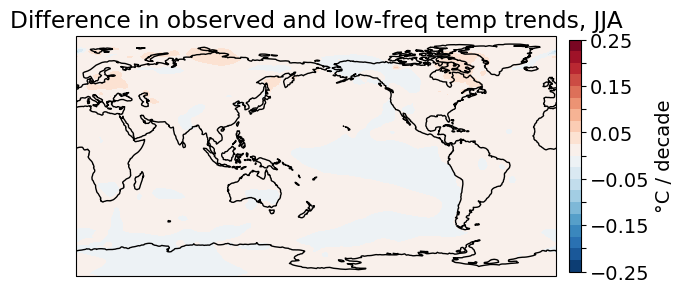

In [19]:
## DIFFERENCE PLOT

#cmap = ncm.cmap('MPL_GnBu')
cmap = 'RdBu_r'
cb_min = -0.25
cb_max = +0.25


fs = 14
f=plt.figure()#figsize=(8,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.title('Difference in observed and low-freq temp trends, JJA', wrap=True)

data = np.array(tas_linear_djf - lfca_spatial_linear[0,:,:])

datamax = np.max(data)
datamin = np.min(data)

data[data<cb_min]=cb_min
data[data>cb_max]=cb_max
data_n, lon_n = add_cyclic_point(data, coord=lon)
cf=plt.contourf(lon_n, lat, data_n, np.linspace(cb_min,cb_max,21),cmap=cmap, transform=ccrs.PlateCarree())

cb=plt.colorbar(cf,fraction = 0.023,pad=0.025)
cb.set_label('°C / decade')
cb.set_ticks(np.arange(-cb_min,cb_max,21))
ax.coastlines()

cb.set_ticks(np.linspace(cb_min,cb_max,11))

n = 2
[l.set_visible(False) for (i,l) in enumerate(cb.ax.yaxis.get_ticklabels()) if i % n != 0]
    
plt.rcParams.update({'font.size':fs})
plt.tight_layout()


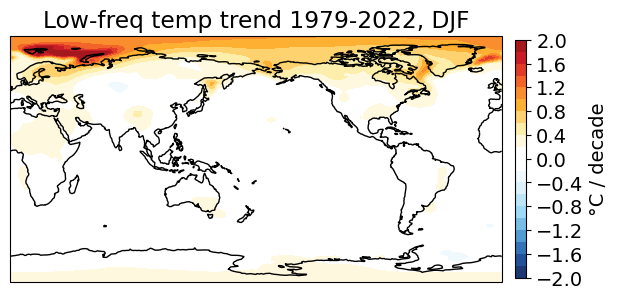

In [154]:
cmap = ncm.cmap('BlueWhiteOrangeRed')
cb_min = -2
cb_max = 2

fs = 14
f=plt.figure() #figsize=(8,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.title('Low-freq temp trend 1979-2022, DJF', wrap=True)

data = np.array(lfca_spatial_linear[0,:,:])

datamax = np.max(data)
datamin = np.min(data)

data[data<cb_min]=cb_min
data[data>cb_max]=cb_max
data_n, lon_n = add_cyclic_point(data, coord=lon)
cf=plt.contourf(lon_n, lat, data_n, np.linspace(cb_min,cb_max,21),cmap=cmap, transform=ccrs.PlateCarree())

cb=plt.colorbar(cf,fraction = 0.023,pad=0.025)
cb.set_label('°C / decade')
cb.set_ticks(np.arange(-cb_min,cb_max,21))
ax.coastlines()

cb.set_ticks(np.linspace(cb_min,cb_max,11))

   
plt.rcParams.update({'font.size':fs})
plt.tight_layout()

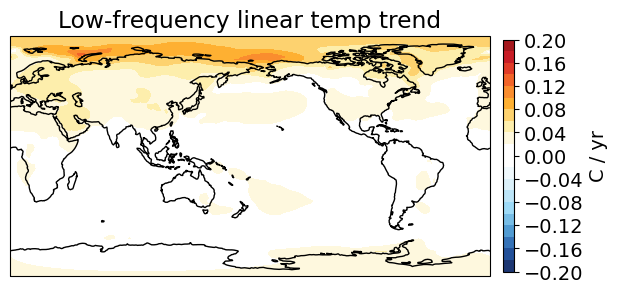

In [14]:
cmap = ncm.cmap('BlueWhiteOrangeRed')
cb_min = -0.2
cb_max = 0.2

fs = 14
f=plt.figure()

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.title('Low-frequency linear temp trend', wrap=True)

data = np.array(lfca_spatial_linear[0,:,:])

datamax = np.max(data)
datamin = np.min(data)

data[data<-1]=-1
data[data>+1]=+1
data_n, lon_n = add_cyclic_point(data, coord=lon)
cf=plt.contourf(lon_n, lat, data_n, np.linspace(cb_min,cb_max,21),cmap=cmap, transform=ccrs.PlateCarree())

cb=plt.colorbar(cf,fraction = 0.023,pad=0.025)
cb.set_label('C / yr')
cb.set_ticks(np.arange(-cb_min,cb_max,21))
ax.coastlines()

cb.set_ticks(np.linspace(cb_min,cb_max,11))

   
plt.rcParams.update({'font.size':fs})
plt.tight_layout()

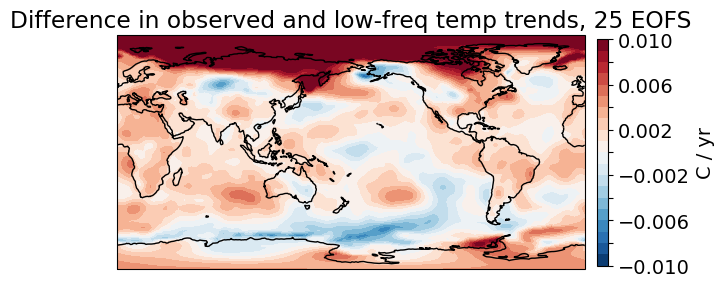

In [15]:
## COMPRESSED DIFFERENCE PLOT

#cmap = ncm.cmap('MPL_GnBu')
cmap = 'RdBu_r'
cb_min = -0.01
cb_max = +0.01


fs = 14
f=plt.figure()#figsize=(8,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.title('Difference in observed and low-freq temp trends, '+str(num_eofs)+' EOFS', wrap=True)

data = np.array(tas_linear - lfca_spatial_linear[0,:,:])

datamax = np.max(data)
datamin = np.min(data)

data[data<cb_min]=cb_min
data[data>cb_max]=cb_max
data_n, lon_n = add_cyclic_point(data, coord=lon)
cf=plt.contourf(lon_n, lat, data_n, np.linspace(cb_min,cb_max,21),cmap=cmap, transform=ccrs.PlateCarree())

cb=plt.colorbar(cf,fraction = 0.023,pad=0.025)
cb.set_label('C / yr')
cb.set_ticks(np.arange(-cb_min,cb_max,21))
ax.coastlines()

cb.set_ticks(np.linspace(cb_min,cb_max,11))

n = 2
[l.set_visible(False) for (i,l) in enumerate(cb.ax.yaxis.get_ticklabels()) if i % n != 0]
    
plt.rcParams.update({'font.size':fs})
plt.tight_layout()


# time periods

In [45]:

## pull spatial linear trend from precip observations in 2000-2012 when there was a hiatus in global warming
yr_a = 2000 - 1979
yr_b = 2012 - 1979

tas_linear_0012 = np.zeros((91,181))
years = range(nyr) + np.ones(nyr)*1979

for lat_ in range(0,91):
    for lon_ in range(0,181):
        prc_anom_pt_ = tas_anom[yr_a:yr_b,lat_,lon_]  # annual
        m,b,rval,pval,errval = sp.stats.linregress(years[21:33], y=prc_anom_pt_, alternative='two-sided')
        tas_linear_0012[lat_,lon_] = m



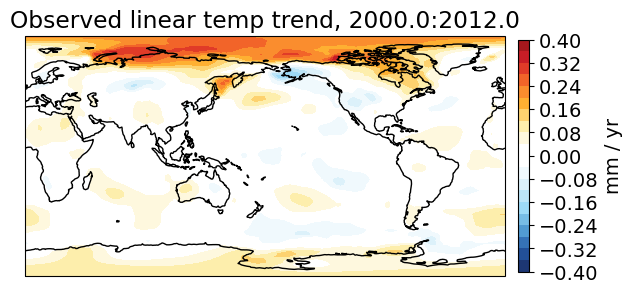

In [48]:
cmap = ncm.cmap('BlueWhiteOrangeRed')
cb_min = -0.4
cb_max = 0.4

fs = 14
f=plt.figure()

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.title('Observed linear temp trend, '+str(years[yr_a].round())+':'+str(years[yr_b].round()))

data = np.array(tas_linear_0012)

datamax = np.max(data)
datamin = np.min(data)

data[data<-1]=-1
data[data>+1]=+1
data_n, lon_n = add_cyclic_point(data, coord=lon)
cf=plt.contourf(lon_n, lat, data_n, np.linspace(cb_min,cb_max,21),cmap=cmap, transform=ccrs.PlateCarree())

cb=plt.colorbar(cf,fraction = 0.023,pad=0.025)
cb.set_label('mm / yr')
cb.set_ticks(np.arange(-cb_min,cb_max,21))
ax.coastlines()

cb.set_ticks(np.linspace(cb_min,cb_max,11))

   
plt.rcParams.update({'font.size':fs})
plt.tight_layout()

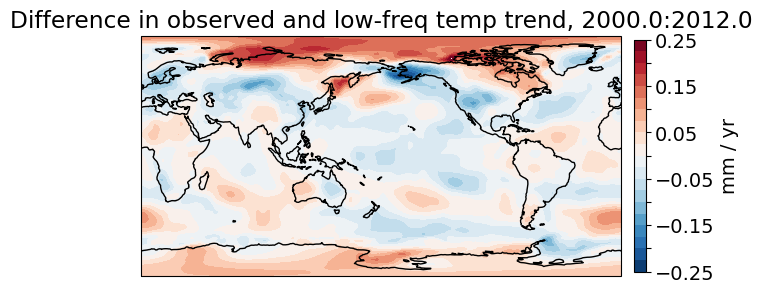

In [49]:
## DIFFERENCE PLOT

#cmap = ncm.cmap('MPL_GnBu')
cmap = 'RdBu_r'
cb_min = -0.25 #-10
cb_max = 0.25 #+10


fs = 14
f=plt.figure()#figsize=(8,8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.title('Difference in observed and low-freq temp trend, '+str(years[yr_a].round())+':'+str(years[yr_b].round()))

data = np.array(tas_linear_0012 - lfca_spatial_linear[0,:,:])

datamax = np.max(data)
datamin = np.min(data)

data[data<-1]=-1
data[data>+1]=+1
data_n, lon_n = add_cyclic_point(data, coord=lon)
cf=plt.contourf(lon_n, lat, data_n, np.linspace(cb_min,cb_max,21),cmap=cmap, transform=ccrs.PlateCarree())

cb=plt.colorbar(cf,fraction = 0.023,pad=0.025)
cb.set_label('mm / yr')
cb.set_ticks(np.arange(-cb_min,cb_max,21))
ax.coastlines()

cb.set_ticks(np.linspace(cb_min,cb_max,11))

n = 2
[l.set_visible(False) for (i,l) in enumerate(cb.ax.yaxis.get_ticklabels()) if i % n != 0]
    
plt.rcParams.update({'font.size':fs})
plt.tight_layout()


In [60]:
lfca_spatial_linear.shape

(20, 91, 181)

In [161]:
tas_anom_lnd[100:155,50:85,:].shape

(55, 35, 44)

In [21]:
filepath="C:/Users/sydne/OneDrive/Documents/LFCA_precip_temp/LFCA_precip_temp/more_data_code/seamask.nc"
data = xr.open_dataset(filepath)
land_mask = np.array(data['topo'])
ocean_mask = (np.nan_to_num(land_mask,nan=0)-1)*-1
ocean_mask[ocean_mask==0]=np.nan

w = np.cos(np.deg2rad(lat))
tas_anom_ocn = np.transpose(np.expand_dims(np.expand_dims(w,0),2)*tas_anom*ocean_mask)
tas_anom_lnd = np.transpose(np.expand_dims(np.expand_dims(w,0),2)*tas_anom*land_mask)
tas_anom_ocn_djf = np.transpose(np.expand_dims(np.expand_dims(w,0),2)*tas_anom_djf*ocean_mask)
tas_anom_lnd_djf = np.transpose(np.expand_dims(np.expand_dims(w,0),2)*tas_anom_djf*land_mask)

# PACIFIC OCEAN
tas_pacific = tas_anom_ocn[55:147,3:80,:]  #[3:80,55:147,:]
#tas_pacific_djf = tas_anom_ocn_djf[3:80,55:147,:]
# components to plot
obs_comp_pac = np.nanmean(np.nanmean(tas_pacific, axis=0),axis=0)
lfca_comp_pac = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*ocean_mask)[:,3:80,55:147], axis=1),axis=1)
#obs_comp_pac_djf = np.nanmean(np.nanmean(tas_pacific_djf, axis=0),axis=0)
#lfca_comp_pac_djf = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial_djf[0,:,:]*ocean_mask)[:,3:80,55:147], axis=1),axis=1)

# NORTH AMERICA

obs_comp_na = np.nanmean(np.nanmean(tas_anom_lnd[100:155,50:85,:], axis=0), axis=0)
lfca_comp_na = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,50:85,100:155], axis=1),axis=1)

# SOUTH AMERICA

obs_comp_sa = np.nanmean(np.nanmean(tas_anom_lnd[130:170,15:52,:], axis=0), axis=0)
lfca_comp_sa = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,15:52,130:170], axis=1),axis=1)

# EUROPE

tem = np.append(np.array(range(170,181)), np.array(range(0,25)))
obs_comp_eur = np.nanmean(np.nanmean(tas_anom_lnd[tem,62:82,:], axis=0), axis=0)
lfca_comp_eur = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,62:82,tem], axis=1),axis=1)

# AFRICA

tem = np.append(np.array(range(170,181)), np.array(range(0,25)))
obs_comp_afr = np.nanmean(np.nanmean(tas_anom_lnd[tem,23:65,:], axis=0), axis=0)
lfca_comp_afr = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,23:65,tem], axis=1),axis=1)

# AUSTRALIA

obs_comp_aus = np.nanmean(np.nanmean(tas_anom_lnd[57:85,21:42,:], axis=0), axis=0)
lfca_comp_aus = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,21:42,57:85], axis=1),axis=1)

# ASIA
obs_comp_asia = np.nanmean(np.nanmean(tas_anom_lnd[25:90,40:85,:], axis=0), axis=0)
lfca_comp_asia = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,40:85,25:90], axis=1),axis=1)

# SOUTHERN OCEAN ZONAL BAND
obs_comp_south = np.nanmean(np.nanmean(tas_anom_ocn[:,7:20,:], axis=0), axis=0)
lfca_comp_south = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*ocean_mask)[:,7:20,:], axis=1),axis=1)


C:\Users\sydne\AppData\Local\Temp\ipykernel_17224\1060413230.py:29: RuntimeWarning: Mean of empty slice
  obs_comp_sa = np.nanmean(np.nanmean(tas_anom_lnd[130:170,15:52,:], axis=0), axis=0)
C:\Users\sydne\AppData\Local\Temp\ipykernel_17224\1060413230.py:30: RuntimeWarning: Mean of empty slice
  lfca_comp_sa = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,15:52,130:170], axis=1),axis=1)
C:\Users\sydne\AppData\Local\Temp\ipykernel_17224\1060413230.py:35: RuntimeWarning: Mean of empty slice
  obs_comp_eur = np.nanmean(np.nanmean(tas_anom_lnd[tem,62:82,:], axis=0), axis=0)
C:\Users\sydne\AppData\Local\Temp\ipykernel_17224\1060413230.py:36: RuntimeWarning: Mean of empty slice
  lfca_comp_eur = np.nanmean(np.nanmean((np.expand_dims(w,1)*lfca_spatial[0,:,:]*land_mask)[:,62:82,tem], axis=1),axis=1)
C:\Users\sydne\AppData\Local\Temp\ipykernel_17224\1060413230.py:41: RuntimeWarning: Mean of empty slice
  obs_comp_afr = np.nanmean(np.nanmean(tas_anom_lnd[tem,23:65,:]

In [304]:
#lat[7:20]

In [265]:
#tas_anom_lnd[tem,23:65,:].shape
#np.nanmean(tas_anom_lnd[tem,23:65,:], axis=0).shape

#tas_anom_lnd[100:155,50:85,:].shape
#tas_anom_lnd.shape
#tas_anom_lnd[175:25,60:80,0].shape
#tem = np.array(range(170,181)).append(np.array(range(0,25)))
#tas_anom_lnd[,:,:].shape

C:\Users\sydne\AppData\Local\Temp\ipykernel_27716\2275797172.py:2: RuntimeWarning: Mean of empty slice
  np.nanmean(tas_anom_lnd[tem,23:65,:], axis=0).shape


(42, 44)

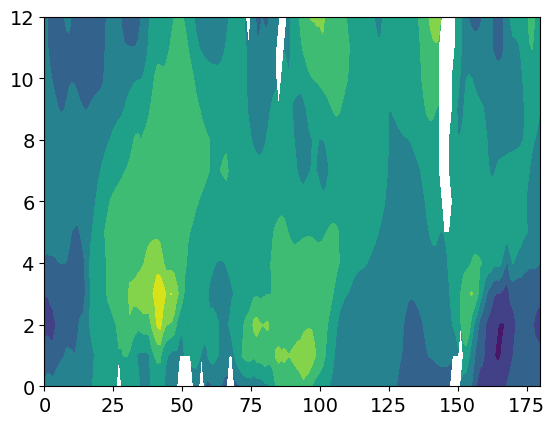

In [299]:
## CONTINENT CHUNKS
plt.figure()
#plt.contourf(np.array(range(55)),np.array(range(35)),np.transpose(tas_anom_lnd[100:155,50:85,0]))

plt.contourf(np.array(range(181)),np.array(range(13)),np.transpose(tas_anom_ocn[:,12:25,0]))

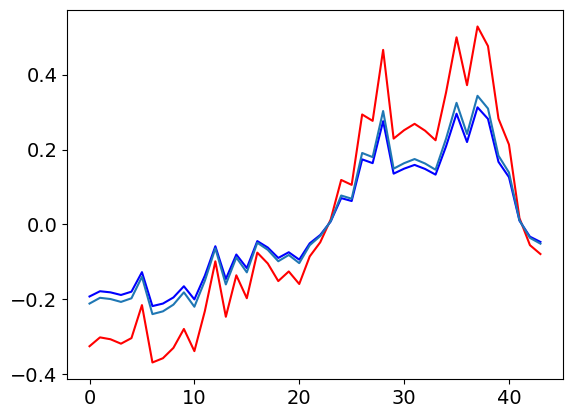

In [286]:
plt.figure()
plt.plot(lfca_comp_na, color='red')
plt.plot(lfca_comp_asia, color = 'blue')
plt.plot(lfca_comp_sa)

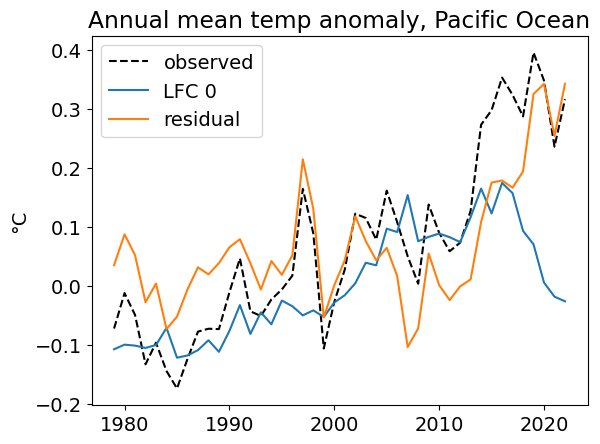

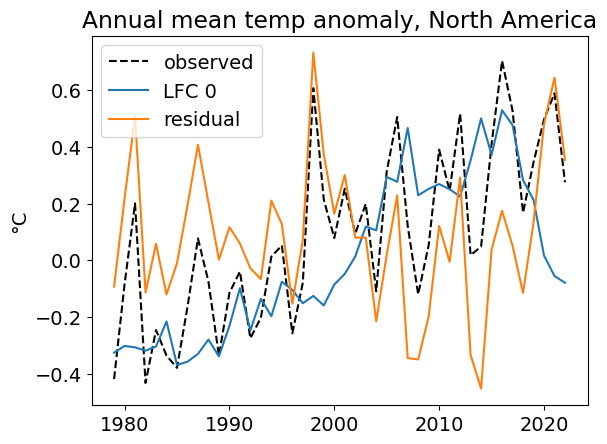

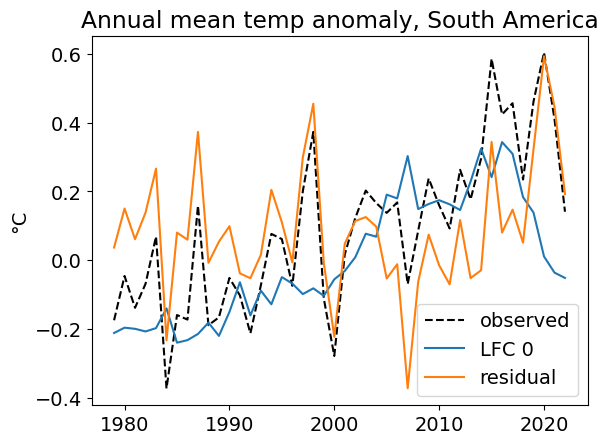

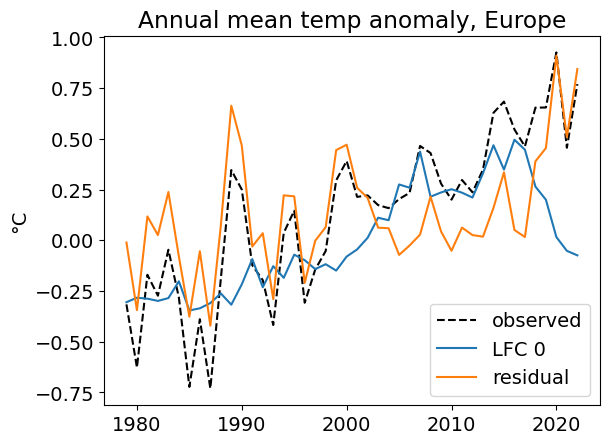

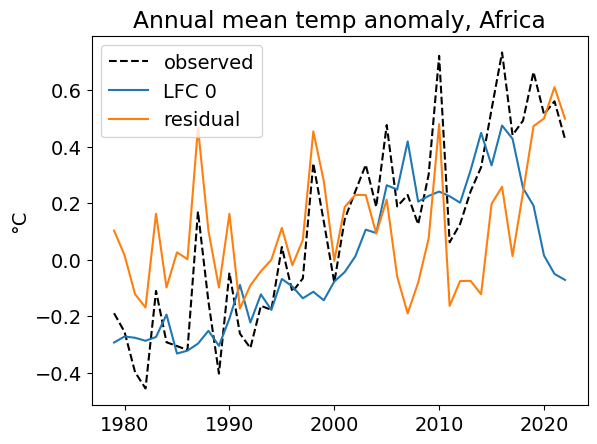

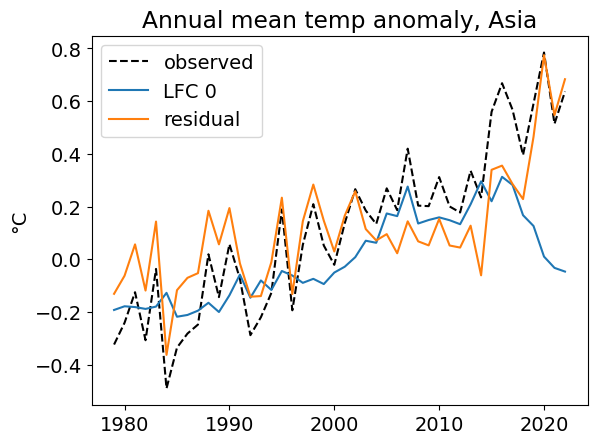

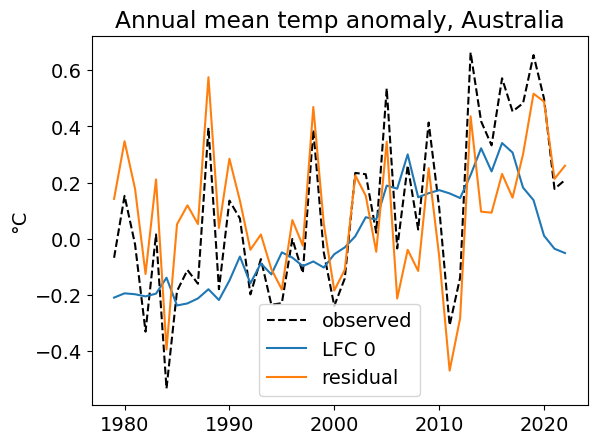

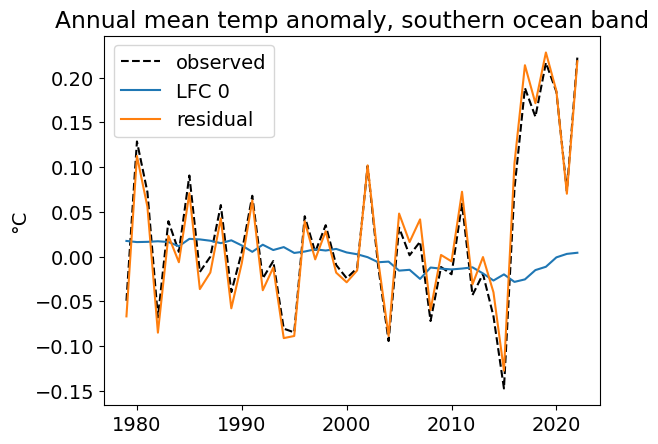

In [22]:
plt.figure()
plt.title('Annual mean temp anomaly, Pacific Ocean')
plt.plot(years, obs_comp_pac, 'k--')
plt.plot(years, lfca_comp_pac)
plt.plot(years, obs_comp_pac - lfca_comp_pac)
plt.ylabel('°C')
plt.legend(['observed','LFC 0', 'residual'])

plt.figure()
plt.title('Annual mean temp anomaly, North America')
plt.plot(years, obs_comp_na, 'k--')
plt.plot(years, lfca_comp_na)
plt.plot(years, obs_comp_na - lfca_comp_na)
plt.ylabel('°C')
plt.legend(['observed','LFC 0','residual'])

plt.figure()
plt.title('Annual mean temp anomaly, South America')
plt.plot(years, obs_comp_sa, 'k--')
plt.plot(years, lfca_comp_sa)
plt.plot(years, obs_comp_sa - lfca_comp_sa)
plt.ylabel('°C')
plt.legend(['observed','LFC 0','residual'])

plt.figure()
plt.title('Annual mean temp anomaly, Europe')
plt.plot(years, obs_comp_eur, 'k--')
plt.plot(years, lfca_comp_eur)
plt.plot(years, obs_comp_eur - lfca_comp_eur)
plt.ylabel('°C')
plt.legend(['observed','LFC 0','residual'])

plt.figure()
plt.title('Annual mean temp anomaly, Africa')
plt.plot(years, obs_comp_afr, 'k--')
plt.plot(years, lfca_comp_afr)
plt.plot(years, obs_comp_afr - lfca_comp_afr)
plt.ylabel('°C')
plt.legend(['observed','LFC 0','residual'])

plt.figure()
plt.title('Annual mean temp anomaly, Asia')
plt.plot(years, obs_comp_asia, 'k--')
plt.plot(years, lfca_comp_asia)
plt.plot(years, obs_comp_asia - lfca_comp_asia)
plt.ylabel('°C')
plt.legend(['observed','LFC 0','residual'])

plt.figure()
plt.title('Annual mean temp anomaly, Australia')
plt.plot(years, obs_comp_aus, 'k--')
plt.plot(years, lfca_comp_aus)
plt.plot(years, obs_comp_aus - lfca_comp_aus)
plt.ylabel('°C')
plt.legend(['observed','LFC 0','residual'])

plt.figure()
plt.title('Annual mean temp anomaly, southern ocean band')
plt.plot(years, obs_comp_south, 'k--')
plt.plot(years, lfca_comp_south)
plt.plot(years, obs_comp_south - lfca_comp_south)
plt.ylabel('°C')
plt.legend(['observed','LFC 0','residual'])

In [91]:
lfca_comp_pac.shape

(44,)